In [1]:
import pandas as pd
import os
import re
from collections import Counter
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
%matplotlib inline
import matplotlib.pyplot as plt

#### Data: https://archive.ics.uci.edu/ml/datasets/Health+News+in+Twitter
#### using only one file NBChealth.txt

In [2]:
path = 'Health-Tweets'
col_names = ['tw_id', 'date', 'tweet']
df = pd.read_csv(os.path.join(path, 'NBChealth.txt'), sep="|", names=col_names)

In [3]:
df.head()

,tw_id,date,tweet
0,548617649010532353,Fri Dec 26 23:13:35 +0000 2014,Ebola Exposure?: CDC Worker 'Remains Well' htt...
1,548569476795731968,Fri Dec 26 20:02:09 +0000 2014,Pregnant Woman Taken Off Life Support in Irela...
2,548533428023738368,Fri Dec 26 17:38:55 +0000 2014,Money from #IceBucketChallenge still flowing t...
3,548531135442337793,Fri Dec 26 17:29:48 +0000 2014,Caramel Apples Recalled After Listeria Deaths ...
4,548194819907284992,Thu Dec 25 19:13:24 +0000 2014,Ice Bucket Challenge Still Rains Bucks on ALS ...


In [4]:
df['processed_date'] = pd.to_datetime(df['date'])
df['day'] = df['processed_date'].dt.date
df.head()

,tw_id,date,tweet,processed_date,day
0,548617649010532353,Fri Dec 26 23:13:35 +0000 2014,Ebola Exposure?: CDC Worker 'Remains Well' htt...,2014-12-26 23:13:35,2014-12-26
1,548569476795731968,Fri Dec 26 20:02:09 +0000 2014,Pregnant Woman Taken Off Life Support in Irela...,2014-12-26 20:02:09,2014-12-26
2,548533428023738368,Fri Dec 26 17:38:55 +0000 2014,Money from #IceBucketChallenge still flowing t...,2014-12-26 17:38:55,2014-12-26
3,548531135442337793,Fri Dec 26 17:29:48 +0000 2014,Caramel Apples Recalled After Listeria Deaths ...,2014-12-26 17:29:48,2014-12-26
4,548194819907284992,Thu Dec 25 19:13:24 +0000 2014,Ice Bucket Challenge Still Rains Bucks on ALS ...,2014-12-25 19:13:24,2014-12-25


In [5]:
df['day'].value_counts().head(10)

2013-10-26    382
2013-10-01     46
2014-02-21     37
2014-02-22     25
2014-05-13     24
2014-10-15     24
2014-03-12     23
2014-10-24     22
2014-03-31     21
2014-04-16     21
Name: day, dtype: int64

In [6]:
# gets all hash tags #,mentions @ 
def get_tw_metrics(mtrc, tw_dt, clm_nm):
    kp_dt = pd.DataFrame()
    kp_dt['tweet'] = tw_dt['tweet']
    kp_dt['hash_tags_list'] = kp_dt['tweet'].apply(lambda v: re.findall(mtrc, v))
    kp_dt['no_hash_tags'] = kp_dt['hash_tags_list'].apply(lambda v: len(v))
    
    # collect all of them in a list, flatten it to find the frequency
    kp_rows = kp_dt[kp_dt['no_hash_tags'] > 0]
    kp_rows_list = kp_rows['hash_tags_list'].tolist()
    kp_combine = [val for sublist in kp_rows_list for val in sublist]

    kp_freq_df = pd.DataFrame.from_dict(Counter(kp_combine), orient='index').reset_index()
    kp_freq_df = kp_freq_df.rename(columns={'index': clm_nm, 0:'count'})
    return kp_freq_df.sort_values('count', ascending=False)

In [7]:
# get top 5 hash tags
all_hash_tags = get_tw_metrics(r"#(\w+)", df, 'hash tags')
print len(all_hash_tags)
print all_hash_tags.head(5)

38
         hash tags  count
10      AskDrNancy     35
16      AskNBCNews     10
5         AgeofAlz      3
37      askdrnancy      3
36  SyriasChildren      3


In [8]:
# get top 5 mentions
all_mentions = get_tw_metrics(r"@(\w+)", df, 'mentions')
print len(all_mentions)
all_mentions.head(5)

61


,mentions,count
7,DrNancyNBCNEWS,13
3,NBCNews,6
16,nbcnightlynews,6
1,NBCNightlyNews,5
29,Larry_Levitt,4


In [9]:
# get all retweets
rt_df = pd.DataFrame()
rt_df['tweet'] = df['tweet']
rt_df['rt'] = rt_df['tweet'].apply(lambda v: 1 if v.startswith("RT") else 0)
rt_df = rt_df[rt_df['rt'] == 1]
print len(rt_df)
rt_df.head(5)

47


,tweet,rt
270,RT @JuliaSommerfeld: Tales of chucking big job...,1
623,RT @JoyJernigan: Yuck! RT @NBCNewsTravel: Vaca...,1
654,RT @TODAYshowHealth: Science of hotness: Stren...,1
726,RT @NBCNightlyNews: When we come back: an incr...,1
912,RT @AkronChildrens: Our NICU is temporary home...,1


In [10]:
# get all tweets with videos in it
video_df = pd.DataFrame()
video_df['tweet'] = df['tweet']
video_df['video_tweets'] = video_df['tweet'].apply(lambda v: 1 if v.find("Video")>=0 else 0)

video_rows = video_df[video_df['video_tweets'] == 1]['tweet']
print len(video_rows)
video_rows

15


163     'Zoning Out Really Bad': Narcolepsy Video Goes...
174     New Brittany Maynard Video Calls For Action ht...
217     Ebola Video Game: Training Medics Far From Haz...
509     'Tingleheads' Say Videos Help Them Sleep http:...
672     Smartphone Selfie Video Leads to Stroke Diagno...
947     Video: TSA Warns Travelers About Deadly MERS V...
1159    Parents Use Viral Video to Try to Save Their 4...
1190    Home Videos Could Help Diagnose Autism, Study ...
1331    Video: Study Finds Mammogram Benefits Oversold...
1379    To Map the Brain, Researchers Create Video Gam...
1439    Viral Video Inspires Moms Expecting Babies Wit...
1460    Video: Families find comfort in tiny hats for ...
2087    Video: Common knee surgery may not alleviate p...
2141    Video: Healthcare sign-ups fall short of origi...
3335    Video: Teens on anxiety: Everything has to be ...
Name: tweet, dtype: object

In [11]:
# get all tweets with links, note there might be some video links coming up again
links_df = pd.DataFrame()
links_df['tweet'] = df['tweet']
links_df['video_tweets'] = links_df['tweet'].apply(lambda v: 1 if v.find("http")>=0 else 0)

links_rows = links_df[links_df['video_tweets'] == 1]['tweet']
print len(links_rows)
links_rows.head(5)

4161


0    Ebola Exposure?: CDC Worker 'Remains Well' htt...
1    Pregnant Woman Taken Off Life Support in Irela...
2    Money from #IceBucketChallenge still flowing t...
3    Caramel Apples Recalled After Listeria Deaths ...
4    Ice Bucket Challenge Still Rains Bucks on ALS ...
Name: tweet, dtype: object

In [12]:
# no. of words in a tweet, sorting it in descending order and see which tweet has the most number of words
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split(" ")))
df.sort_values('word_count', ascending=False)[['tw_id', 'tweet', 'word_count']].head(5)

,tw_id,tweet,word_count
2876,385063521047691264,RT @BeganRight: #AskDrNancy If you do not pay ...,29
2894,385059145151311873,RT @ConnSherrie: #AskDrNancy If our 2014 W-2 i...,27
3165,356853781343911936,RT @DrNancyNBCNEWS: A new study tonight with a...,26
2879,385062978531254272,.@brandonburkman If u get a job with health in...,26
2886,385061215161942016,RT @7Blasdel7: #AskDrNancy Im a recent college...,26


#### to look up the tweet in the twitter the tweet id can be used
#### https://stackoverflow.com/questions/897107/can-i-fetch-the-tweet-from-twitter-if-i-know-the-tweets-id

In [13]:
#### no. of characters
df['char_count'] = df['tweet'].str.len()
df.sort_values('char_count', ascending=False)[['tw_id', 'tweet', 'char_count']].head(5)

,tw_id,tweet,char_count
2976,377911698620833792,My colleague Bill Dedman on The Daily Show las...,178
2149,410408174814908416,This woman sure showed some persistence in get...,175
2148,410408762332037120,"Biggest threat to cancer progress? Congress, c...",168
1154,458335295520264192,RT @NBCNews: Failing at Fertility: New 'report...,167
2277,399925637559119872,RT @DrNancyNBCNEWS: No admissions. No supplies...,164


In [14]:
# avg word length
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

df['avg_word'] = df['tweet'].apply(lambda x: avg_word(x))
df.sort_values('avg_word', ascending=False)[['tw_id', 'tweet', 'avg_word']].head(5)

,tw_id,tweet,avg_word
2144,410798897787723776,"California parents demand meningitis vaccine, ...",22
2146,410771809458323456,Health insurance exchanges still see slow enro...,17
2145,410798691218231296,FDA targets antibiotics in meat http://www.nbc...,16
2149,410408174814908416,This woman sure showed some persistence in get...,15
2148,410408762332037120,"Biggest threat to cancer progress? Congress, c...",15


In [15]:
# no. of numerics
df['numerics'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df[['tweet','numerics']].sort_values('numerics', ascending=False).head(5)

,tweet,numerics
3244,1 in 3 women globally has been abused by partn...,2
2190,"More than 1 in 10 US kids has ADHD, survey sho...",2
1346,"22 Pens, 47 Million Americans: Obamacare by th...",2
927,22 Most Outrageous Baby Names of 2013 http://n...,2
337,Oh Boy! Couple With 12 Sons Expecting Baby No....,2


In [16]:
# no. of upper characters
df['upper'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df[['tweet','upper']].sort_values('upper', ascending=False).head(5)

,tweet,upper
4079,RT @melissadahl: BREAKING CHILDREN'S LITERATUR...,5
2873,RT @Curly_Lumpkin: @NBCNewsHealth self employe...,4
908,"Illinois Man is Third U.S. MERS Infection, CDC...",3
270,RT @JuliaSommerfeld: Tales of chucking big job...,3
2937,A one-third drop in new AIDS infections: UN re...,3


In [17]:
def remove_garbage(text):

    """Replace non-word (non-alphanumeric) chars in text with spaces,
       Remove numbers, hyperlinks
       then convert and return a lowercase version of the result.
    """
    url_reg  = r'[a-z]*[:.]+\S+'
    text = re.sub(url_reg, '', text)
    
    text = re.sub(r'\W+', ' ', text)
    
    text = re.sub(" \d+", " ", text)
    text = text.lower()
    return text

In [18]:
def remove_stopwords(wordlist, stopwords):
    return [w for w in wordlist if w not in stopwords]

In [19]:
def remove_short_words(wordlist):
    return [w for w in wordlist if len(w) > 3]

In [20]:
# lets draw a wordcloud, after doing some preprocessing
def draw_wordcloud(freq_dict):
    # Generate a word cloud image
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=50, max_font_size=110)
    wordcloud.generate_from_frequencies(freq_dict)
    # Display the generated image:
    # the matplotlib way:
    
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    return

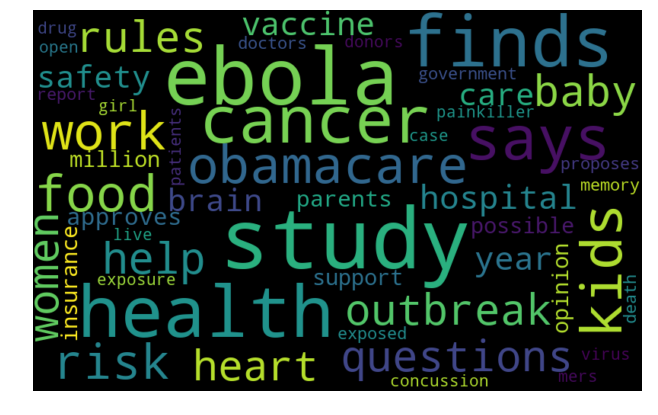

In [21]:
ugrms_cnter = Counter()
for line in df['tweet']:
    line = line.split("|")[-1]
    fil_words = remove_garbage(line)
    cleaned_words = remove_stopwords(fil_words.split(), ENGLISH_STOP_WORDS)
    cleaned_words = remove_short_words(cleaned_words)
    ugrms_cnter.update(cleaned_words)

draw_wordcloud(ugrms_cnter)